# Load

In [68]:
import sys
sys.path.append('../gym')

from PIL import Image

from paintings import PaintingEnv
import numpy as np
import pandas as pd
from collections import defaultdict, namedtuple, deque

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model

from tqdm import tqdm
import seaborn as sns

In [ ]:
model = InceptionV3(weights='imagenet')
#base_model = InceptionV3(weights='imagenet')
#model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [2]:
env = PaintingEnv()

In [3]:
import agent
#from importlib import reload
#agent = reload(agent)
Agent = agent.Agent

# People

This shows how well the human subjects did in terms of their average reward per trial.

In [59]:
dat = pd.read_csv("y_data_catlearn.csv", index_col=0).reset_index(drop=True)
dat.head()

,trial,subject,ttype,run,gallery_left,gallery_right,art_left,art_right,stim_left,stim_right,...,chosen_val,chosen_gal,chosen_art,chosen_stim,unchosen_val,unchosen_gal,unchosen_art,unchosen_stim,chosen_val_grp,unchosen_val_grp
0,1,29svyahw,learn_value,1,Cordelia,Cordelia,Mon,Mon,Monb2n.jpeg,Monb1n.jpeg,...,80.0,Cordelia,Mon,Monb2n.jpeg,60.0,Cordelia,Mon,Monb1n.jpeg,high,high
1,2,29svyahw,learn_value,1,Cordelia,Cordelia,Mon,Mon,Mondb2.jpeg,Mondb3.jpeg,...,60.0,Cordelia,Mon,Mondb2.jpeg,40.0,Cordelia,Mon,Mondb3.jpeg,high,high
2,3,29svyahw,learn_value,1,Cordelia,Marina,Mon,Rot,Monb3n.jpeg,Rota1n.jpeg,...,20.0,Marina,Rot,Rota1n.jpeg,60.0,Cordelia,Mon,Monb3n.jpeg,low,high
3,4,29svyahw,learn_value,1,Marina,Marina,Rot,Rot,Rothb2.jpeg,Rota1n.jpeg,...,20.0,Marina,Rot,Rothb2.jpeg,20.0,Marina,Rot,Rota1n.jpeg,low,low
4,5,29svyahw,learn_value,1,Marina,Cordelia,Rot,Mon,Rothb2.jpeg,Monb2n.jpeg,...,80.0,Cordelia,Mon,Monb2n.jpeg,20.0,Marina,Rot,Rothb2.jpeg,high,low


In [67]:
human_scores = dat.groupby('subject').agg({'chosen_val': 'mean'})/100
human_scores

,chosen_val
subject,
0c5elj2l,0.422222
0q4hzu7r,0.448889
0rx8wkq0,0.462222
1w1m6w5v,0.417978
1x880j6k,0.426667
...,...
xskb7u61,0.482222
yko5at2v,0.484444
yv9953n7,0.457778


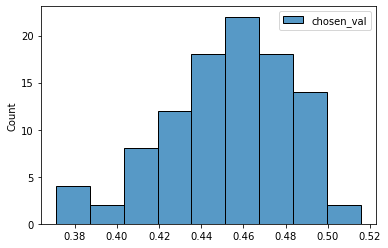

In [69]:
sns.histplot(human_scores)

In [70]:
np.mean(human_scores)

chosen_val    0.452585
dtype: float64

# Run RL

In [26]:
def preprocess_image(im):
    img = im.resize((299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [38]:
def preprocess_states(states):
    xs = [ preprocess_image(Image.fromarray(state)) for state in states ]
    xs = np.vstack(xs)
    obj_states = model.predict(xs)
    obj_states = obj_states.flatten()
    return obj_states

In [73]:
def dqn(agent, n_episodes=1000, eps_start=1.0, eps_end=0.1, eps_decay=0.995, train_mode=True, 
        ckpt_path='pth_checkpoints/checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        agent (Agent): The agent
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train_mode (bool): if 'True' set environment to training mode
        
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    moving_avgs = []                   # list of moving averages
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, reward, done, info = env.reset(full_reset=False) # reset environment
        score = 0
        for t in range(env.n_trials - 1):
            pp_state = preprocess_states(state)                 # from raw pixels to high-lvl visual reps
            action = agent.act(pp_state, eps)                   # select an action
            next_state, reward, done, info = env.step(action)   # send action to environment
            pp_next_state = preprocess_states(next_state)       # from raw pixels to high-lvl visual reps
            agent.step(pp_state, action, reward, pp_next_state, done) # learning step
            state = next_state
            score += reward
            if done:
                break
        mean_score = score/t # keep scores in range of 0-1, allow comparison to humans above
        scores_window.append(mean_score)          # save most recent score to window
        scores.append(mean_score)                 # save most recent score to total
        moving_avg = np.mean(scores_window)  # calculate moving average
        moving_avgs.append(moving_avg)       # save most recent moving average
        eps = max(eps_end, eps_decay*eps)    # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg), end="")
        if i_episode % 5 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg))
    return scores, moving_avgs

In [74]:
config_dict = {
    'seed': 42, 
    'buffer_size': int(1e2), 
    'batch_size': 32, 
    'gamma': 0.99, 
    'tau': 1e-2, 
    'loss_type': 'huber',
    'gradient_clip': None, 
    'update_every': 4, 
    'lr': 5e-4, 
    'fc1_units': 64, 
    'fc2_units': 32, 
    'use_ddqn': False,
    'use_dueling': False, 
    'use_per': False,
    'per_a': 0.5, 
    'per_beta': 0.5
}
agent = Agent(state_size=1000*2, action_size=2, config_dict=config_dict)
scores, avgs = dqn(agent, n_episodes=100, eps_decay=0.98, eps_end=0.1)

Episode 5	Average Score: 0.39
Episode 10	Average Score: 0.39
Episode 15	Average Score: 0.39
Episode 20	Average Score: 0.40
Episode 25	Average Score: 0.41
Episode 30	Average Score: 0.42
Episode 35	Average Score: 0.42
Episode 40	Average Score: 0.43
Episode 45	Average Score: 0.43
Episode 50	Average Score: 0.44
Episode 55	Average Score: 0.44
Episode 60	Average Score: 0.44
Episode 65	Average Score: 0.45
Episode 70	Average Score: 0.45
Episode 75	Average Score: 0.45
Episode 77	Average Score: 0.46

KeyboardInterrupt: 

In [75]:
# Set the learning rate to be faster and a smaller batch size
config_dict = {
    'seed': 42, 
    'buffer_size': int(1e2), 
    'batch_size': 16, 
    'gamma': 0.99, 
    'tau': 1e-2, 
    'loss_type': 'huber',
    'gradient_clip': None, 
    'update_every': 4, 
    'lr': 5e-2, 
    'fc1_units': 64, 
    'fc2_units': 32, 
    'use_ddqn': False,
    'use_dueling': False, 
    'use_per': False,
    'per_a': 0.5, 
    'per_beta': 0.5
}
agent = Agent(state_size=1000*2, action_size=2, config_dict=config_dict)
scores, avgs = dqn(agent, n_episodes=100, eps_decay=0.98, eps_end=0.1)

Episode 5	Average Score: 0.39
Episode 10	Average Score: 0.41
Episode 15	Average Score: 0.41
Episode 20	Average Score: 0.42
Episode 25	Average Score: 0.42
Episode 30	Average Score: 0.43
Episode 35	Average Score: 0.43
Episode 40	Average Score: 0.43
Episode 45	Average Score: 0.43
Episode 50	Average Score: 0.44
Episode 55	Average Score: 0.44
Episode 60	Average Score: 0.44
Episode 65	Average Score: 0.44
Episode 70	Average Score: 0.45


KeyboardInterrupt: 